In [1]:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.formula.api import ols
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

import model

In [2]:
train = pd.read_csv('train.csv')

In [3]:
# We are trying to predict Value based on baths, beds and sq. ft
y = train[['value']]
X = train[['bathrooms', 'bedrooms', 'square_feet']]

In [4]:
# Create predictions dataframe
predictions = pd.DataFrame({
    'actual': train.value,
    'baseline': train.value.mean()
})
predictions

,actual,baseline
0,386909.000,540348.743
1,780000.000,540348.743
2,117583.000,540348.743
3,588770.000,540348.743
4,424532.000,540348.743
...,...,...
11986,221876.000,540348.743
11987,88594.000,540348.743
11988,461938.000,540348.743
11989,630544.000,540348.743


In [5]:
X_bath = train[['bathrooms']]

lm_bath = LinearRegression(normalize=False).fit(X_bath, y)
predictions['bath_lm'] = lm_bath.predict(X_bath)

In [6]:
X_bed = train[['bedrooms']]

lm_bed = LinearRegression(normalize=False).fit(X_bed, y)
predictions['bed_lm'] = lm_bed.predict(X_bed)

In [7]:
X_sf = train[['square_feet']]

lm_sf = LinearRegression(normalize=False).fit(X_sf, y)
predictions['sf_lm'] = lm_sf.predict(X_sf)

In [10]:
X = train[['bathrooms', 'bedrooms', 'square_feet']]

poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)
lm_poly = LinearRegression(normalize=False).fit(X_poly, y)
predictions['poly'] = lm_poly.predict(X_poly)

In [11]:
# use RFE to select top 2

model.select_rfe(X, y, 2)

['bathrooms', 'bedrooms']


In [12]:
X_rfe = train[['bathrooms', 'bedrooms']]

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_rfe)
lm_rfe = LinearRegression(normalize=False).fit(X_poly, y)
predictions['rfe'] = lm_rfe.predict(X_poly)

In [13]:
# But given the correlations, I think sq feet is more important than bedrooms
X_corr = train[['bathrooms', 'square_feet']]

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_corr)
lm_corr = LinearRegression(normalize=False).fit(X_poly, y)
predictions['corr'] = lm_corr.predict(X_poly)

In [14]:
# make an ols model with all 3
ols_model = ols('value ~ bathrooms + bedrooms + square_feet', data=train).fit()
predictions['ols'] = ols_model.predict(X)

In [15]:
predictions

,actual,baseline,bath_lm,bed_lm,sf_lm,poly,rfe,corr,ols
0,386909.000,540348.743,603893.417,688320.114,902648.361,651623.819,450146.390,683633.495,845332.535
1,780000.000,540348.743,47173.361,254923.752,289533.670,431648.699,323965.856,347205.902,385061.410
2,117583.000,540348.743,789466.769,688320.114,819663.795,601119.345,617437.352,669898.315,782389.631
3,588770.000,540348.743,789466.769,471621.933,500084.935,584443.513,661783.142,476033.954,579163.012
4,424532.000,540348.743,47173.361,254923.752,15419.758,153355.727,323965.856,253267.488,86678.163
...,...,...,...,...,...,...,...,...,...
11986,221876.000,540348.743,603893.417,688320.114,585717.945,421858.138,450146.390,486647.771,500341.921
11987,88594.000,540348.743,418320.065,471621.933,150931.789,247419.435,363299.790,266898.309,144318.951
11988,461938.000,540348.743,418320.065,471621.933,351772.094,335137.678,363299.790,350316.328,362941.137
11989,630544.000,540348.743,603893.417,471621.933,357951.796,403651.306,485218.080,368847.196,397056.873


In [16]:
# now set up the evaluation functions
# I want the RMSE of each model

In [17]:
RMSE_bl = model.RMSE(predictions.actual, predictions.baseline)
RMSE_bath = model.RMSE(predictions.actual, predictions.bath_lm)
RMSE_bed = model.RMSE(predictions.actual, predictions.bed_lm)
RMSE_sf = model.RMSE(predictions.actual, predictions.sf_lm)
RMSE_poly = model.RMSE(predictions.actual, predictions.poly)
RMSE_rfe = model.RMSE(predictions.actual, predictions.rfe)
RMSE_corr = model.RMSE(predictions.actual, predictions['corr'])
RMSE_ols = model.RMSE(predictions.actual, predictions.ols)

In [18]:
eval = pd.DataFrame(np.array(['baseline', 'bath', 'bed', 'sq_feet', 'poly', 'rfe', 'corr', 'ols']), columns=['models'])
eval['model_errors'] = np.array([RMSE_bl, RMSE_bath, RMSE_bed, RMSE_sf, RMSE_poly, RMSE_rfe, RMSE_corr, RMSE_ols])

eval.sort_values(by='model_errors')

,models,model_errors
4,poly,547653.250
6,corr,567372.227
7,ols,588589.536
3,sq_feet,597347.745
5,rfe,599484.529
1,bath,637657.044
2,bed,712699.608
0,baseline,741315.642


In [19]:
# This means that the model made using all 3 values performs the best
# Also, all models performed better than the baseline

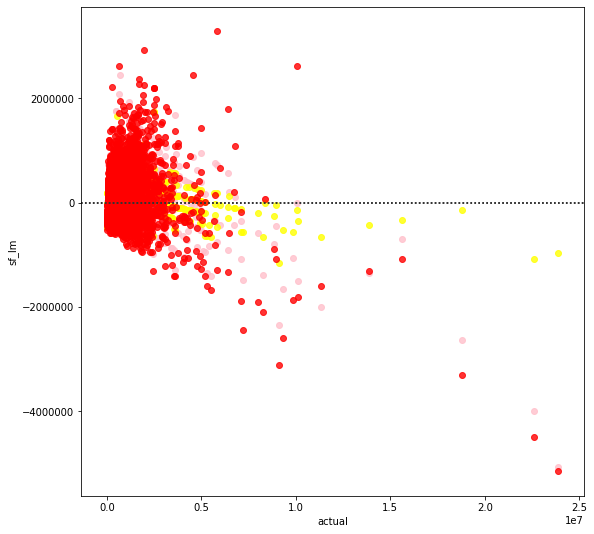

In [20]:
# plot residuals
plt.figure(figsize=(9, 9))

sns.residplot(predictions.actual, predictions.bath_lm, color='pink')
sns.residplot(predictions.actual, predictions.bed_lm, color='yellow')
sns.residplot(predictions.actual, predictions.sf_lm, color='red')

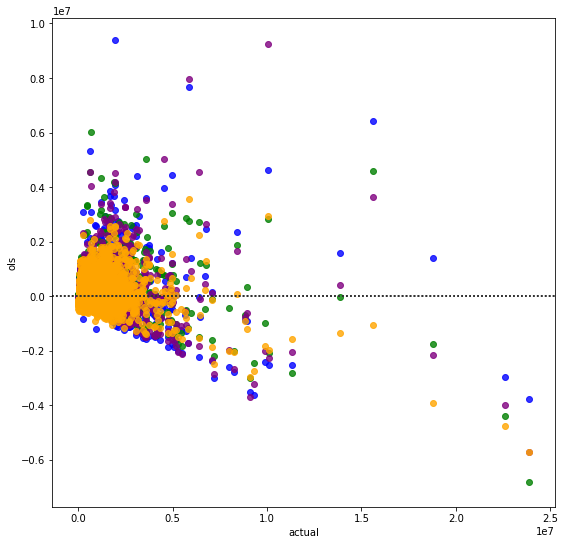

In [21]:
# plot residuals
plt.figure(figsize=(9, 9))

sns.residplot(predictions.actual, predictions.poly, color='blue')
sns.residplot(predictions.actual, predictions.rfe, color='green')
sns.residplot(predictions.actual, predictions['corr'], color='purple')
sns.residplot(predictions.actual, predictions.ols, color='orange')